# Strategy Implementation

## Introduction

In this project, we explore the application of Deep Reinforcement Learning (DRL) for trading multiple stocks. The strategy leverages DRL to analyze and make trading decisions across a selected portfolio of stocks. Reinforcement learning, a type of machine learning, trains an agent to make decisions by rewarding desired actions and penalizing undesired ones. In the context of stock trading, this DRL agent learns to predict actions—whether to buy, hold, or sell a stock—based on historical market data and technical indicators such as MACD and RSI. The process is iterative, with the agent continuously refining its strategy based on the outcomes of its actions to maximize the portfolio's value over time. By applying DRL, we aim to harness the potential of artificial intelligence to navigate the stock market's complexities and uncover profitable trading opportunities.

## Data Preprocessing

Imported all libraries needed to preprocess data and build deep learning model.

In [26]:
import pandas as pd
import numpy as np
import matplotlib 
import yfinance as yf
from stockstats import StockDataFrame
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
import stable_baselines3 
from stable_baselines3 import DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback

Imported stock data of all 8 stocks from Yahoo Finance from 2010-2023.

In [27]:
tickers = ['AAPL', 'KO', 'MSFT', 'F', 'PEP', 'TSLA', 'JNJ', 'PFE']
stocks = yf.download(tickers, start = "2010-08-01", end = "2023-12-31")
stocks.head()

[*********************100%%**********************]  8 of 8 completed


Price      Adj Close                                                        \
Ticker          AAPL         F        JNJ         KO       MSFT        PEP   
Date                                                                         
2010-08-02  7.917214  7.574693  39.373192  18.599459  20.117464  43.736916   
2010-08-03  7.919638  7.430798  39.795624  18.589571  19.987576  44.071953   
2010-08-04  7.951382  7.545914  40.057121  18.645622  19.659031  44.339981   
2010-08-05  7.912684  7.471088  40.070545  18.586269  19.383974  43.944637   
2010-08-06  7.863999  7.505622  40.204651  18.711569  19.521515  44.159065   

Price                              Close         ...       Open            \
Ticker           PFE      TSLA      AAPL      F  ...        PFE      TSLA   
Date                                             ...                        
2010-08-02  8.748160  1.394667  9.351786  13.16  ...  14.383302  1.366667   
2010-08-03  9.234169  1.463333  9.354643  12.91  ...  15.180266  1.400000   
2010-08-04  9.394167  1.417333  9.392143  13.11  ...  15.426945  1.463333   
2010-08-05  9.251308  1.363333  9.346429  12.98  ...  15.550285  1.436000   
2010-08-06  9.279882  1.306000  9.288929  13.04  ...  15.237192  1.340000   

Price          Volume                                                    \
Ticker           AAPL          F       JNJ        KO      MSFT      PEP   
Date                                                                      
2010-08-02  428055600   77124700  11455600  32091200  55044600  6479700   
2010-08-03  417653600  115202600  10855100  15427400  56877700  5577200   
2010-08-04  420375200   60875000  10508800  11974400  78531900  6663800   
2010-08-05  289097200   51574800   9796700  15099800  64922100  5143100   
2010-08-06  444897600   54704600   8524100  18090600  55982100  5500700   

Price                            
Ticker            PFE      TSLA  
Date                             
2010-08-02   57746657  10771500  
2010-08-03  167802492  18457500  
2010-08-04   77121707  13695000  
2010-08-05   77704147  11943000  
2010-08-06   54416966  11128500  

[5 rows x 48 columns]

Using the stockstats library to calculate RSI, MACD, and ATR for each stock. These technical indicators will be used as features in the deep learning model.

In [28]:
indicators_df = pd.DataFrame()
# Iterate over each ticker to calculate indicators and merge them into the stocks DataFrame
for ticker in tickers:
    # Extract the ticker-specific data from the MultiIndex DataFrame
    ticker_data = stocks.loc[:, pd.IndexSlice[:, ticker]].copy()
    # Convert column MultiIndex to single level using the ticker as a suffix
    ticker_data.columns = ticker_data.columns.droplevel(1)
    
    # Convert to StockDataFrame for calculating indicators
    sdf = StockDataFrame.retype(ticker_data)
    sdf['rsi'] = sdf.get('rsi_30')
    sdf['macd'] = sdf.get('macd')
    sdf['atr'] = sdf.get('atr_30')
    
    # Prepare the indicator data for merging
    indicators = sdf[['rsi', 'macd', 'atr']]
    
    # Add indicators to the indicators_df DataFrame with MultiIndex columns
    for indicator in indicators:
        indicators_df[(indicator, ticker)] = indicators[indicator]

#Merge the indicators_df with the original stocks DataFrame
stocks = pd.concat([stocks, indicators_df], axis=1)

# Sort the MultiIndex columns to maintain order and flatten to single index df for simplicity
# Drop all yfinance data that will not be used in machine learning model
stocks = stocks.sort_index(axis=1)
level_0 = stocks.columns.get_level_values(0).unique()
keep_levels = ['Adj Close', 'rsi', 'macd', 'atr']
drop_levels = [level for level in level_0 if level not in keep_levels]
stocks = stocks.drop(columns=drop_levels, level=0)
stocks = stocks.rename(columns = {'rsi' : 'RSI', 'macd' : 'MACD', 'atr' : 'ATR'})
stocks.columns = ['_'.join(col).strip() for col in stocks.columns.values]

Calculating overall turbulence index for the portfolio. The turbulence index is used to measure major events that affect the stock market. Incorporating the turbulence index to clear out all positions if the market is unstable.

In [29]:

def calculate_turbulence(df):
    """Calculate the turbulence index for a given DataFrame containing adjusted close prices."""
    adj_close_cols = [col for col in df.columns if 'Adj Close' in col]
    df_returns = df[adj_close_cols].pct_change().dropna()
    start = 252
    turbulence_index = [0] * start
    
    # Calculate the turbulence index starting after the initial period
    for i in range(start, len(df_returns)):
        current_returns = df_returns.iloc[i]
        hist_returns = df_returns.iloc[:i]
        
        cov_matrix = hist_returns.cov()
        
        mean_returns = hist_returns.mean()
        deviation = current_returns - mean_returns
        
        # Calculate the inverse of the covariance matrix
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        temp = deviation.dot(inv_cov_matrix).dot(deviation.T)
        turbulence_temp = temp if temp > 0 else 0
        
        turbulence_index.append(turbulence_temp)
    
    # Extend the turbulence index list to match the length of the DataFrame if necessary
    while len(turbulence_index) < len(df):
        turbulence_index.append(0)
    
    # Assign the turbulence index to the DataFrame
    df['Turbulence'] = turbulence_index
    
    return df

stocks = calculate_turbulence(stocks)


## Feature Engineering

This following section includes processing the dataframe and feature engineering to ensure that the data can be correctly inputted into the deep learning model.

In [30]:
# Unpivot the DataFrame
df_long = stocks.reset_index().melt(id_vars= ['Date', 'Turbulence'])

# Extract ticker and indicator
df_long['Ticker'] = df_long['variable'].apply(lambda x: x.split('_')[-1])
df_long['Indicator'] = df_long['variable'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Drop the original 'variable' column as it's no longer needed
df_long.drop('variable', axis=1, inplace=True)

# Pivot to get 'Indicator' as columns, and keep 'Ticker' as a column
df_wide = df_long.pivot_table(index=['Date', 'Ticker', 'Turbulence'], columns='Indicator', values='value').reset_index()

# Format the df to 8 rows per date for each stock ticker. Each date has one index so 
# each index number aligns with 8 rows
df_wide.columns.name = None
df_wide = df_wide.rename_axis(None, axis=1)
stocks = df_wide
stocks = stocks.rename(columns = {'Adj Close' : 'AdjCl', 'macd' : 'MACD', 'atr' : 'ATR'})
date_to_index = {date: idx for idx, date in enumerate(stocks['Date'].unique())}
stocks['date_idx'] = stocks['Date'].map(date_to_index)
stocks.set_index('date_idx', inplace=True)

## DRL Environment 

In order to build a reinforcement learning model to optimize the portfolio holdings, I created an environment that simulates the stock market and built functions allowing the model to buy and sell shares of the 8 stocks to maximize portfolio returns. This environment is solely used for training so it doesn't include the turbulence index and risk free rate in calculating the Sharpe Ratio.

Used FinRL to help develop stock trading environment 

In [27]:
# 100 shares per trade
HMAX = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE = 100000
# total number of stocks in our portfolio
STOCK_DIM = 8

REWARD_SCALING = 1e-4

class StockTrain(gym.Env):
    
    #The init function initializes the environment and sets the action space and the state space. The
    #state space includes the account balance, adj close, technical indicators, and the shares owned.
    #The action space is [-1, 1], where 1 is a buy, 0 is a hold, and -1 is a sell. 
    def __init__(self, df, day = 0):
        super(StockTrain, self).__init__()
        self.day = day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,))
        # Shape = 41: [Current Balance]+[adj close 1-8]+[owned shares 1-8]
        # +[macd 1-8]+ [rsi 1-8] + [atr 1-8]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (41,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.AdjCl.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.MACD.values.tolist() + \
                      self.data.RSI.values.tolist() + \
                      self.data.ATR.values.tolist()
        self.reward = 0
        self.cost = 0
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        self._seed()
    
    #This function analyzes the reward function and determines whether to sell shares of any of the stocks
    def _sell_stock(self, index, action):
        if self.state[index + STOCK_DIM + 1] > 0:
            self.state[0] += \
            self.state[index+1] * min(abs(action), self.state[index + STOCK_DIM + 1]) 
            self.state[index + STOCK_DIM + 1] -= min(abs(action), self.state[index + STOCK_DIM + 1])
            self.cost += self.state[index + 1]* min(abs(action),self.state[index + STOCK_DIM + 1]) 
            self.trades+=1
        else:
            pass
    
    #This function analyzes the reward function and determines whether to buy shares of any of the stocks
    def _buy_stock(self, index, action):
        available_amount = self.state[0] // self.state[index+1]
        self.state[0] -= self.state[index + 1] * min(available_amount, action) 
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        self.cost+=self.state[index+1] * min(available_amount, action) 
        self.trades+=1
    
    # The `step` function advances the environment by one timestep based on the agent's action. It processes the action (buying or selling stocks),
    # updates the environment's state, calculates the immediate reward based on the action's outcome, and checks if the episode has ended. 
    # It returns the new state, the calculated reward, a boolean indicating if the episode is over, and an empty info dictionary.
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1
        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value_train.png')
            plt.close()
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))

            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):17]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5) * df_total_value['daily_return'].mean() / df_total_value['daily_return'].std()
            print("Sharpe: ", sharpe)
            print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards_train.csv')
            return self.state, self.reward, self.terminal, {}
        else:
            actions = actions * HMAX

            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):17]))
            #print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])

            for index in buy_index:
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.state =  [self.state[0]] + \
                    self.data.AdjCl.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):17]) + \
                    self.data.MACD.values.tolist() + \
                    self.data.RSI.values.tolist() + \
                    self.data.ATR.values.tolist()

            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):17]))
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)

            self.reward = self.reward * REWARD_SCALING
            # print("step_reward:{}".format(self.reward))

            self.asset_memory.append(end_total_asset)
            return self.state, self.reward, self.terminal, {}
    
    # The `reset` function is called at the beginning of a new episode to reset the environment's state to its initial condition. 
    # It initializes the environment with the starting account balance, resets the current day to 0, and prepares the initial state 
    # with stock data for the first day. It returns the initial state of the environment.
    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                    self.data.AdjCl.values.tolist() + \
                    [0]*STOCK_DIM + \
                    self.data.MACD.values.tolist() + \
                    self.data.RSI.values.tolist() + \
                    self.data.ATR.values.tolist()
        return self.state
    
    # The `_seed` function sets the seed of the environment's random number generator to ensure reproducibility of the environment's randomness.
    # This is useful for debugging or comparing the performance of different algorithms under the same set of random events in the environment.
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    

        

The following StockTrade environment is very similar to the training environment with the difference being that a couple of additional factors are included to account for economic principles that affect the stock market. Namely, the risk free rate is used in calculating the Sharpe ratio and the turbulence index is used to account for drastic events that may affect the whole stock market and manage portfolio risk accordingly.

In [38]:
#Comments are only provided in this class for aspects that differ from the StockTrain class as the
#environments are nearly identical

# 100 shares per trade
HMAX = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE = 100000
# total number of stocks in our portfolio
STOCK_DIM = 8

REWARD_SCALING = 1e-4

class StockTrade(gym.Env):
    def __init__(self, df, day = 0, turbulence_threshold = 140):
        super(StockTrade, self).__init__()
        self.day = day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,))
        # Shape = 41: [Current Balance]+[adj close 1-8]+[owned shares 1-8]
        # +[macd 1-8]+ [rsi 1-8] + [atr 1-8]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (41,))
        self.data = self.df.loc[self.day,:]
        self.trade_history = []
        self.terminal = False
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.AdjCl.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.MACD.values.tolist() + \
                      self.data.RSI.values.tolist() + \
                      self.data.ATR.values.tolist()
        self.reward = 0
        self.turbulence = 0
        self.turbulence_threshold = turbulence_threshold
        self.cost = 0
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        self.actions_memory=[]
        self.date_memory=[]
        self._seed()
    
    
    # The buy and sell functions are nearly identical except for the fact that the turbulence index is 
    # accounted for when making buy or sell decisions.
    def _sell_stock(self, index, action):
        if self.turbulence < self.turbulence_threshold:
            if self.state[index + STOCK_DIM + 1] > 0:
                self.trade_history.append({'date': self.day, 'action': 0})
                self.state[0] += \
                self.state[index+1] * min(abs(action), self.state[index + STOCK_DIM + 1]) 
                self.state[index + STOCK_DIM + 1] -= min(abs(action), self.state[index + STOCK_DIM + 1])
                self.cost += self.state[index + 1]* min(abs(action),self.state[index + STOCK_DIM + 1]) 
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions
            if self.state[index+STOCK_DIM+1] > 0:
                self.trade_history.append({'date': self.day, 'action': 0})
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]
                self.trades+=1
            else:
                pass     

    def _buy_stock(self, index, action):
        if self.turbulence< self.turbulence_threshold:
            self.trade_history.append({'date': self.day, 'action': 1})
            available_amount = self.state[0] // self.state[index+1]
            self.state[0] -= self.state[index + 1] * min(available_amount, action) 
            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            self.cost+=self.state[index+1] * min(available_amount, action) 
            self.trades+=1
        else:
            pass
    
    # This step function differs from the previous one by including terminal state handling, 
    # where it saves various performance metrics (like account value, trade history, and actions taken) 
    # to files, calculates and prints the Sharpe ratio using a dynamic risk-free rate, and logs final
    # asset values and total rewards.
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1
        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value_train.png')
            plt.close()
            
            df_date = pd.DataFrame(self.date_memory)
            df_date.columns = ['Date']
            df_date.to_csv('df_date.csv')
            
            df_actions = pd.DataFrame(self.actions_memory)
            df_actions.columns = self.data.Ticker.values
            df_actions.index = df_date.Date
            df_actions.to_csv('df_actions.csv')
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value_train.csv')
            
            df_total_trades = pd.DataFrame(self.trade_history)
            df_total_trades.to_csv('trade_history.csv')
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM + 1)])*np.array(self.state[(STOCK_DIM + 1):(STOCK_DIM * 2 + 1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))

            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):17])) - self.asset_memory[0]))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            def get_dynamic_risk_free_rate():
                treasury_data = yf.download("^TNX", start = "2022-01-01", end = "2023-12-31")
                risk_free_rate = treasury_data['Adj Close'].iloc[-1] / 100 / 252
                return risk_free_rate

            risk_free_rate = get_dynamic_risk_free_rate()
            sharpe = (252**0.5) * (df_total_value['daily_return'].mean() - risk_free_rate) / df_total_value['daily_return'].std()
            print("Sharpe: ", sharpe)
            print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards_train.csv')
            return self.state, self.reward, self.terminal, {}
        
        else:
            self.date_memory.append(self.data.Date.unique())
            actions = actions * HMAX

            if(self.turbulence >= self.turbulence_threshold):
                actions=np.array([-HMAX]*STOCK_DIM)
            self.actions_memory.append(actions)
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])

            for index in buy_index:
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.turbulence = self.data['Turbulence'].values[0]
            self.state =  [self.state[0]] + \
                    self.data.AdjCl.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):17]) + \
                    self.data.MACD.values.tolist() + \
                    self.data.RSI.values.tolist() + \
                    self.data.ATR.values.tolist()

            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):17]))
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)

            self.reward = self.reward * REWARD_SCALING
            # print("step_reward:{}".format(self.reward))

            self.asset_memory.append(end_total_asset)
            return self.state, self.reward, self.terminal, {}

    
    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[]
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                    self.data.AdjCl.values.tolist() + \
                    [0]*STOCK_DIM + \
                    self.data.MACD.values.tolist() + \
                    self.data.RSI.values.tolist() + \
                    self.data.ATR.values.tolist()
        return self.state
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


        

## Deep Reinforcement Learning Model

The following code block includes a function used for splitting a dataframe by the date column. I used the function to split the dataframe into a train dataframe and test dataframe.

In [32]:
def data_split(df, start, end):
    data = df[(df.Date >= start) & (df.Date < end)]
    data = data.sort_values(['Date','Ticker'],ignore_index=True)
    data.index = data.Date.factorize()[0]
    return data

train_data = data_split(stocks, '2011-01-01', '2022-01-01')
test_data = data_split(stocks, '2022-01-01', '2024-03-06')

The following code creates an instance of the StockTrain environment class using the train data so that it can be utilized to train the Deep Deterministic Policy Gradient (DDPG). The DDPG (Deep Deterministic Policy Gradient) model is a deep reinforcement learning (DRL) algorithm that operates in continuous action spaces, making it well-suited for tasks like portfolio management where actions are not simply binary or discrete choices. It combines deep learning with a policy gradient approach, employing two neural networks: the actor, which proposes actions given the current state of the stock market, and the critic, which evaluates the proposed actions based on the potential future rewards. By training on historical data, the DDPG model learns to optimize portfolio returns by continuously adjusting its trading strategy based on both the success of past actions and the current market conditions. Once the model is trained, it is saved locally.

In [36]:
env_train = DummyVecEnv([lambda: StockTrain(train_data)])
n_actions = env_train.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(mean = np.zeros(n_actions), sigma = float(0.5) * np.ones(n_actions))

model_ddpg = DDPG('MlpPolicy',
                   env_train,
                   batch_size=64,
                   buffer_size=100000,
                   action_noise=action_noise,
                   verbose=1)

model_ddpg.learn(total_timesteps=250000, tb_log_name="stock_train_1")
model_ddpg.save("ssmif_stocktrader")

/Users/rajshah/miniforge3/envs/tensorflow/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


previous_total_asset:100000
end_total_asset:1494888.1762860613
total_reward:1394888.1762860613
total_cost:  3282891.6803551195
total_trades:  12797
Sharpe:  1.2712858986037003
previous_total_asset:100000
end_total_asset:1073335.1150758103
total_reward:973335.1150758103
total_cost:  346047.0371452842
total_trades:  9116
Sharpe:  1.1539861423476532
previous_total_asset:100000
end_total_asset:1485428.9297034715
total_reward:1385428.9297034715
total_cost:  257377.723671474
total_trades:  9208
Sharpe:  1.1521420350978941
previous_total_asset:100000
end_total_asset:1044721.0386217079
total_reward:944721.0386217079
total_cost:  99999.1912153577
total_trades:  9668
Sharpe:  1.1707307296044949
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 282      |
|    time_elapsed    | 39       |
|    total_timesteps | 11076    |
| train/             |          |
|    actor_loss      | 469      |
|    critic_loss     | 200      |


The following code creates an instance of the StockTrade environment to simulate the actual market. The trained model from the previous step is used to effectively allocate portfolio holdings to maxmize profits over the given time period.

In [39]:
model_ddpg = DDPG.load("/Users/rajshah/Downloads/SSMIF S24 Coding Challenge/Q2 - Algorithmic Trading/ssmif_stocktrader.zip")
env_test = DummyVecEnv([lambda: StockTrade(test_data)])
obs_test = env_test.reset()
def DRL_prediction(model, data, env, obs):
    for i in range(len(data.Date.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

DRL_prediction(model_ddpg, test_data, env_test, obs_test)

/Users/rajshah/miniforge3/envs/tensorflow/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
[*********************100%%**********************]  1 of 1 completed

previous_total_asset:100000
end_total_asset:112264.44778442383
total_reward:12264.447784423828
total_cost:  99972.30166625977
total_trades:  1500
Sharpe:  0.20473116421683948


## Plot (P/L) and (Buy and Hold)

## Compare the strategy and buy and hold's sharpe ratio

The following code plots a profit/loss graph of the DRL algorithm versus the profit/loss graph of a simple buy and hold strategy that allocates the intial cash value equally among the 8 stocks ($12,500 per stock). The Sharpe Ratio for both the DRL algorithm and the buy and hold strategy is calculated to measure the performance of the DRL the algorithm relative to the simple buy and hold strategy.

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  8 of 8 completed


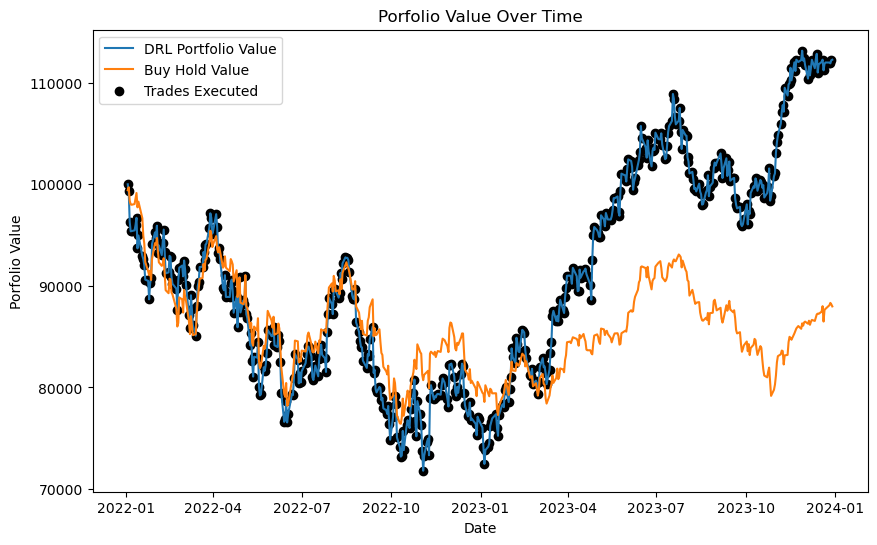

Initial Portfolio Value: 100000
DRL Final Portfolio Value:  112264.44778442384
DRL Sharpe Ratio:  0.20473116421684182
Buy Hold Final Portfolio Value:  87975.14941215515
Buy Hold Sharpe Ratio:  -0.4626464847622438


In [48]:
def get_pl_sharpe(returns, test_data, trade_history):
    risk_free_rate = get_dynamic_risk_free_rate()
    sharpe_bh, portfolio_values = getBuyHoldReturns(risk_free_rate)
    date_mapping = test_data.groupby('Date').first().reset_index()
    trade_history['date_index'] = trade_history['date'] 
    trade_history['actual_date'] = trade_history['date_index'].map(date_mapping['Date'])
    returns['Date'] = returns.index.map(date_mapping['Date'])
    returns['daily_return'] = returns.d_returns.pct_change(1)
    trade_counts_per_day = trade_history.groupby('actual_date')['action'].count().reset_index()
    max_trades = trade_counts_per_day['action'].max()
    trade_counts_per_day['normalized_count'] = trade_counts_per_day['action'] / max_trades
    plt.figure(figsize=(10, 6))
    plt.plot(returns['Date'], returns['d_returns'], label='DRL Portfolio Value')
    plt.plot(portfolio_values.index, portfolio_values, label='Buy Hold Value')
    flag = False
    for _ , row in trade_counts_per_day.iterrows():
        if row['actual_date'] in returns['Date'].values:
            portfolio_value = returns.loc[returns['Date'] == row['actual_date'], 'd_returns'].iloc[0]
            if not flag: 
                plt.scatter(row['actual_date'], portfolio_value, color='black', 
                            alpha=row['normalized_count'], label = 'Trades Executed')
                flag = True
            else: 
                plt.scatter(row['actual_date'], portfolio_value, color='black', 
                            alpha=row['normalized_count'])           
    plt.xlabel('Date')
    plt.ylabel('Porfolio Value')
    plt.title('Porfolio Value Over Time')
    plt.legend()
    plt.show()
    
    sharpe_drl = (252**0.5) * (returns['daily_return'].mean() - risk_free_rate) / returns['daily_return'].std()
    
    print("Initial Portfolio Value: 100000")
    print("DRL Final Portfolio Value: ", returns['d_returns'].iloc[-1])
    print("DRL Sharpe Ratio: ", sharpe_drl)
    print("Buy Hold Final Portfolio Value: ", portfolio_values.iloc[-1])
    print("Buy Hold Sharpe Ratio: ", sharpe_bh)
    
def get_dynamic_risk_free_rate():
    treasury_data = yf.download("^TNX", start = "2022-01-01", end = "2023-12-31")
    risk_free_rate = treasury_data['Adj Close'].iloc[-1] / 100 / 252
    return risk_free_rate

def getBuyHoldReturns(risk_free_rate):
    tickers = ['AAPL', 'MSFT', 'KO', 'F', 'PEP', 'TSLA', 'JNJ', 'PFE']
    initial_investment = 12500
    data = yf.download(tickers, start='2022-01-01', end='2023-12-31')['Adj Close']

    # Calculate initial shares: divide initial investment by the first available price
    initial_prices = data.iloc[0]
    initial_shares = initial_investment // initial_prices
    
    # Calculate daily portfolio value
    daily_values = (data * initial_shares).sum(axis=1)
    
    # Calculate daily returns of the portfolio
    daily_returns = daily_values.pct_change().dropna()
    
    # Calculate the Sharpe Ratio
    # Adjust the risk_free_rate to daily if it's given as an annual rate
    risk_free_rate_daily = risk_free_rate 
    excess_returns = daily_returns - risk_free_rate_daily
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    
    return sharpe_ratio, daily_values


returns = pd.read_csv('account_value_train.csv')
returns.columns.values[1] = 'd_returns'
trade = pd.read_csv('trade_history.csv')

get_pl_sharpe(returns, test_data, trade)

    

## Conclusion

The DRL algorithm had a return of $12,264 over the course of Jan 2022-Dec 2023. While the algorithm may be somewhat volatile with a Sharpe Ratio of 0.205, the algorithm had about a 12% return, indicating the profitability of the algorithm. In comparison, the buy and hold strategy had a loss of about 12%, with a Sharpe ratio of -0.463. Overall, I am enthusiastic about the DRL algorithm and am eager to find ways to optimize it going forwards.